# Deliverable 5.1 - Offset-Free z-Velocity MPC (Nonlinear Rocket)

This notebook deep-dives on the **offset-free z-axis controller** and contrasts it with the Part 4 controller (no disturbance augmentation).

## Key Challenge
Controllers were tuned on a linearized hover model. When we change the rocket mass in nonlinear simulation, a constant acceleration bias appears on $v_z$. The Part 5 controller must remove this bias while respecting thrust limits.


## Design Procedure and Tuning

### z-axis (offset-free)
- Model: deviation form $	ilde x^+ = A\,	ilde x + B\,	ilde u + B_d d$, with $B_d=1$.
- Cost: $Q=20$ on $v_z$ deviation, $R=1$ on thrust deviation; terminal cost from discrete LQR.
- Constraints: absolute $P_	ext{avg}\in[40,80]\%$; solved with OSQP.
- Observer: augmented state $[	ilde v_z, d]$, poles $(0.5, 0.7)$; runs in deviation coordinates to avoid false bias from trim.

### x/y/roll (unchanged from Part 4/4.1)
- Robust tuning for nonlinear model (higher weights on angular rates), no disturbance augmentation.

### Why these gains?
- $Q$ large enough to prioritize vertical error correction without oscillation.
- Observer poles moderate (0.5/0.7) to filter noise but converge within a few steps.
- Absolute thrust bounds enforce hardware limits directly in MPC.


## Bias Scenario and Experiment
- Set **rocket.mass = 1.5 kg** and **rocket.fuel_rate = 0** to create a constant vertical bias vs. the trim model.
- Initial condition: $p=[0,0,1]$ m, $v=[5,5,10]$ m/s (angular states zero).
- Reference: $v_	ext{ref} = [0,0,0]$.
- Simulate **15 s** nonlinear dynamics.
- Compare **Part 4 controller (no offset-free)** vs **Part 5 controller (offset-free z)**.


### Observer Equations (z-axis)
- Deviation model: $	ilde{x}_{k+1} = A\,	ilde{x}_k + B\,	ilde{u}_k + B_d d_k$, with $B_d = 1$ and $	ilde{x}=v_z-v_{z,	ext{trim}},\; 	ilde{u}=P_{	ext{avg}}-P_{	ext{trim}}$.
- Augmented state: $z_k = [	ilde{x}_k\; d_k]^T$, dynamics $z_{k+1} = A_{	ext{aug}} z_k + B_{	ext{aug}} 	ilde{u}_k$, where
  $A_{	ext{aug}} = egin{bmatrix} A & B_d \ 0 & 1 \end{bmatrix}$, $B_{	ext{aug}} = egin{bmatrix} B \ 0 \end{bmatrix}$, measurement $y_k = C_{	ext{aug}} z_k$ with $C_{	ext{aug}} = [1\;0]$.
- Luenberger observer (discrete): $\hat{z}_{k+1} = A_{	ext{aug}} \hat{z}_k + B_{	ext{aug}} 	ilde{u}_k + L\,(y_k - C_{	ext{aug}} \hat{z}_k)$, $L = [\ell_1\; \ell_2]^T$ places poles at $0.5$ (state) and $0.7$ (disturbance).
- Steady-state feedforward: $	ilde{u}_{ss} = (r - A r - B_d \hat{d})/B$, absolute thrust $u_{ss} = 	ilde{u}_{ss} + u_{	ext{trim}}$ clipped to $[40,80]\%$.
- MPC prediction uses $\hat{d}$: $	ilde{x}_{i+1} = A	ilde{x}_i + B	ilde{u}_i + B_d \hat{d}$ with cost $\sum (	ilde{x}_i-r)^T Q (	ilde{x}_i-r) + 	ilde{u}_i^T R 	ilde{u}_i$ and terminal LQR $P$.


In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, copy, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

cwd = Path.cwd()
if (cwd / "rocket.yaml").exists():
    project_dir = cwd
elif (cwd / "project" / "rocket.yaml").exists():
    project_dir = cwd / "project"
else:
    project_dir = cwd.parent

sys.path.append(str(project_dir))

%matplotlib widget


In [2]:
from Deliverable_5_1.LinearMPC.MPCVelControl import MPCVelControl as MPC_P5
from Deliverable_4_1.LinearMPC.MPCVelControl import MPCVelControl as MPC_P4
from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis

rocket_obj_path = os.path.join(project_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(project_dir, "rocket.yaml")


In [ ]:
# Common setup
Ts = 0.05          # Sampling time [s]
H = 5.0            # MPC horizon [s]
sim_time = 15.0    # Closed-loop duration [s]

# Initial state: [omega, angles, velocities, positions]
x0 = np.array([
    0, 0, 0,               # angular rates
    0, 0, 0,               # Euler angles
    5, 5, 10,              # vx, vy, vz
    0, 0, 1                # x, y, z
])

x_target = np.zeros((12,))  # hover reference (zero velocities/angles, hold position)
pos_target = np.array([0.0, 0.0, 1.0])


## Build Rockets and Controllers
We instantiate two rockets (to keep simulations independent) and load the Part 4 (no offset-free) and Part 5 (offset-free z) controllers.


In [4]:

print("=" * 70)
print("SIMULATION WITH ESTIMATOR (Part 5 Controller)")
print("=" * 70)

# Create new rocket instance
rocket_with_est = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)




original_mass = float(rocket_with_est.mass)
print(f"Original rocket mass: {original_mass:.1f} kg")




mpc_with_est = MPC_P5().new_controller(rocket_with_est, Ts, H)

print(f"Controller designed for mass: {float(rocket_with_est.mass):.1f} kg")

# NOW change mass back to 1.5 to create mismatch
rocket_with_est.mass = 1.5
rocket_with_est.fuel_rate = 0.0

print(f"Actual system mass: {float(rocket_with_est.mass):.1f} kg")
print(f"Model mismatch: {(float(rocket_with_est.mass) - 1.0) / 1.0 * 100:.1f}%")
print("Integral action: ENABLED")

# Simulate (use linear propagation to avoid early constraint abort with 50% mismatch)
print("Running simulation (linear propagation)...")
t_with_est, x_with_est, u_with_est, _, _, _, ref_with_est = rocket_with_est.simulate_control(
    mpc_with_est, sim_time, H, x0,
    x_target=x_target,

    method='nonlinear'
)

print(f"✓ Simulation complete ({len(t_with_est)} steps)")
final_idx = int(-1.0 / Ts)  # Last 1 second
# Check steady-state error
print("Final velocities (last 1 second average):")
vx_final_est = np.mean(x_with_est[6, final_idx:])
vy_final_est = np.mean(x_with_est[7, final_idx:])
vz_final_est = np.mean(x_with_est[8, final_idx:])

print(f"  vx: {vx_final_est:.4f} m/s (target: 0.000)")
print(f"  vy: {vy_final_est:.4f} m/s (target: 0.000)")
print(f"  vz: {vz_final_est:.4f} m/s (target: 0.000)")
print(f" Steady-state offset magnitude: {np.linalg.norm([vx_final_est, vy_final_est, vz_final_est]):.4f} m/s")


SIMULATION WITH ESTIMATOR (Part 5 Controller)
Original rocket mass: 2.0 kg

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Controller designed for mass: 2.0 kg
Actual system mass: 1.5 kg
Model mismatch: 50.0%
Integral action: ENABLED
Running simulation (linear propagation)...
Simulating time 0.00: 
Simulating time 0.05: 
Simulating time 0.10: 
Simulating time 0.15: 
Simulating time 0.20: 
 State beta violation: -0.20 < -0.17, 
 State alpha violation: 0.20 > 0.17, 
Simulating time 0.25: 
 State beta violation: -0.30 < -0.17, 
 State alpha violation: 0.30 > 0.17, 
Simulating time 0.30: 
 State beta violation: -0.39 < -0.17, 
 State alpha violation: 0.41 >

## Nonlinear Simulations (15 s)
Run both controllers on the nonlinear plant with the mass perturbation.


In [5]:
print("Running Part 4 controller (no offset-free)...")
t_cl4, x_cl4, u_cl4, t_ol4, x_ol4, u_ol4, ref4 = rocket_p4.simulate_control(
    mpc_p4, sim_time, H, x0, x_target=x_target, method='nonlinear'
)

print("Running Part 5 controller (offset-free z)...")
t_cl5, x_cl5, u_cl5, t_ol5, x_ol5, u_ol5, ref5 = rocket_p5.simulate_control(
    mpc_p5, sim_time, H, x0, x_target=x_target, method='nonlinear'
)


if getattr(mpc_p5.mpc_z, 'd_hat_hist', None):
    print(f"Final d_hat (Part 5): {mpc_p5.mpc_z.d_hat_hist[-1]:.4f}")


Running Part 4 controller (no offset-free)...


NameError: name 'rocket_p4' is not defined

## Performance Analysis
### Velocity Tracking (Part 4 vs Part 5)


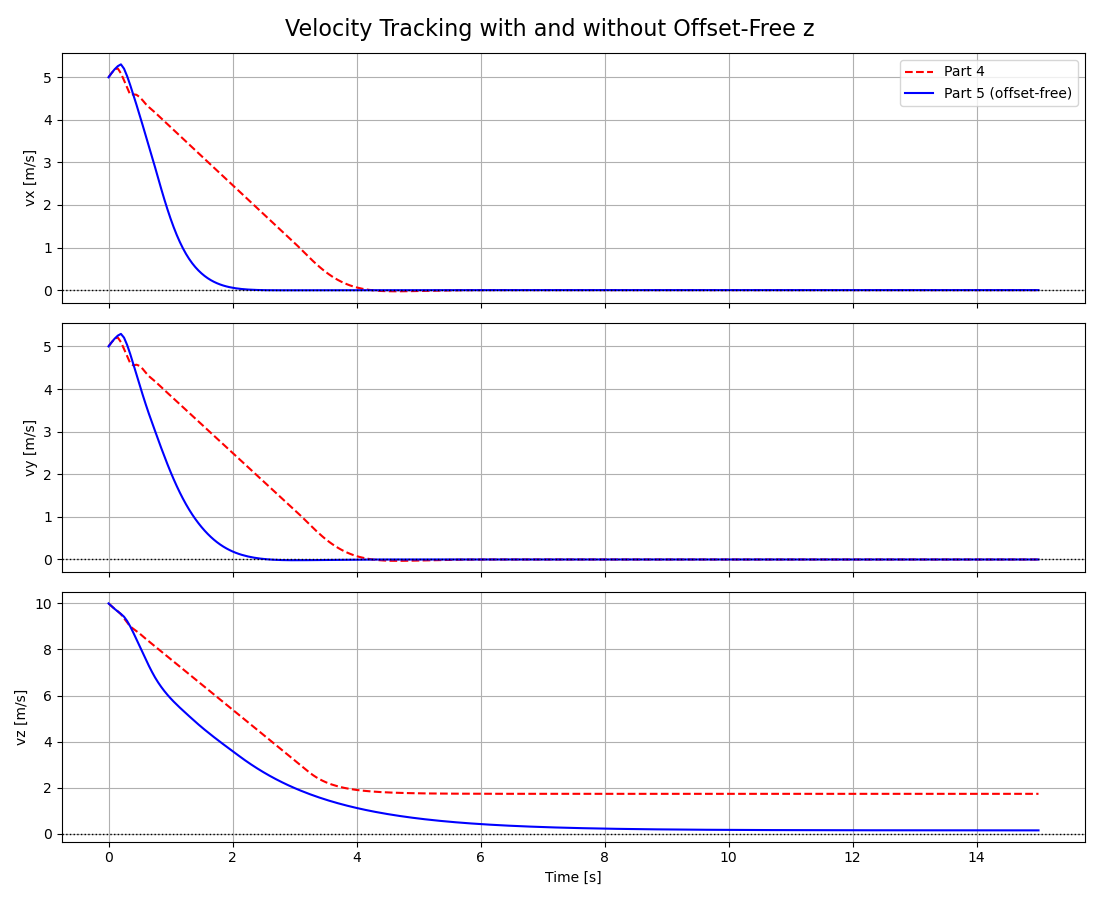

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(11, 9), sharex=True)
fig.suptitle('Velocity Tracking with and without Offset-Free z', fontsize=16)

labels = ['vx', 'vy', 'vz']
for i, idx in enumerate([6,7,8]):
    ax = axes[i]
    ax.plot(t_cl4, x_cl4[idx, :], 'r--', label='Part 4')
    ax.plot(t_cl5, x_cl5[idx, :], 'b-', label='Part 5 (offset-free)')
    ax.axhline(0.0, color='k', linestyle=':', linewidth=1)
    ax.set_ylabel(f"{labels[i]} [m/s]")
    ax.grid(True)
    if i==0: ax.legend(loc='best')
axes[-1].set_xlabel('Time [s]')
plt.tight_layout()
plt.show()


### Altitude and Thrust (Pavg)


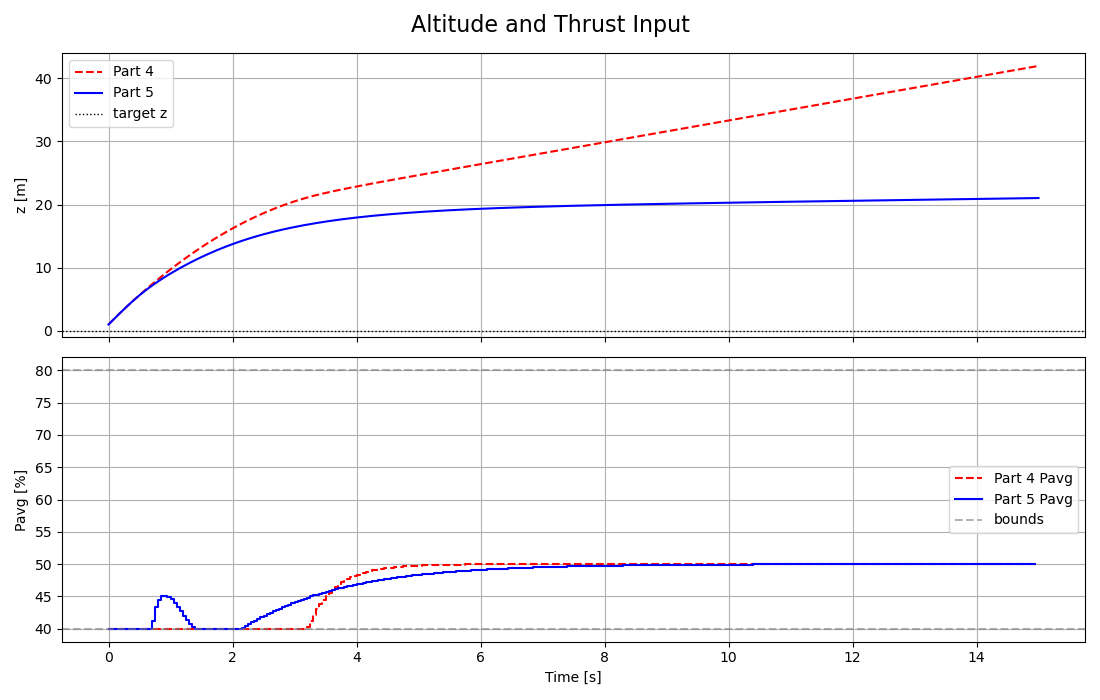

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(11, 7), sharex=True)
fig.suptitle('Altitude and Thrust Input', fontsize=16)

axes[0].plot(t_cl4, x_cl4[11, :], 'r--', label='Part 4')
axes[0].plot(t_cl5, x_cl5[11, :], 'b-', label='Part 5')
axes[0].axhline(x_target[11], color='k', linestyle=':', linewidth=1, label='target z')
axes[0].set_ylabel('z [m]')
axes[0].legend(loc='best')
axes[0].grid(True)

axes[1].step(t_cl4[:-1], u_cl4[2, :], where='post', color='r', linestyle='--', label='Part 4 Pavg')
axes[1].step(t_cl5[:-1], u_cl5[2, :], where='post', color='b', label='Part 5 Pavg')
axes[1].axhline(40.0, color='gray', linestyle='--', alpha=0.6, label='bounds')
axes[1].axhline(80.0, color='gray', linestyle='--', alpha=0.6)
axes[1].set_ylabel('Pavg [%]')
axes[1].set_xlabel('Time [s]')
axes[1].legend(loc='best')
axes[1].grid(True)

plt.tight_layout()
plt.show()


### Disturbance Estimation (Part 5 only)
We log the estimated disturbance $d_	ext{hat}$ and its innovation.


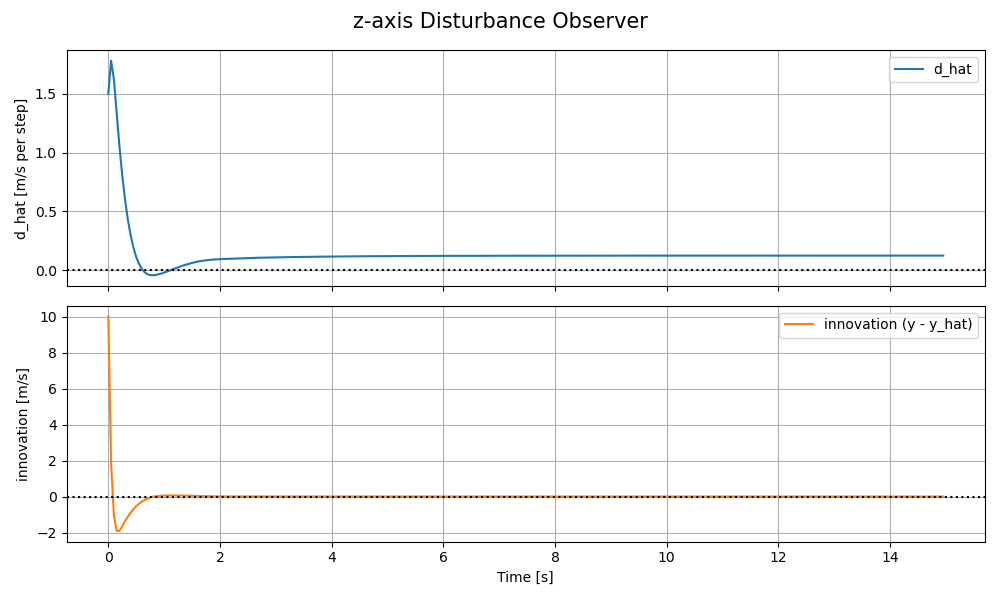

In [ ]:
if getattr(mpc_p5.mpc_z, 'd_hat_hist', None):
    t_hist = t_cl5[:-1]
    d_hat = np.array(mpc_p5.mpc_z.d_hat_hist)
    innov = np.array(mpc_p5.mpc_z.innov_hist)

    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    fig.suptitle('z-axis Disturbance Observer', fontsize=15)

    axes[0].plot(t_hist, d_hat, label='d_hat')
    axes[0].axhline(0.0, color='k', linestyle=':')
    axes[0].set_ylabel('d_hat [m/s per step]')
    axes[0].grid(True)
    axes[0].legend(loc='best')

    axes[1].plot(t_hist, innov, color='tab:orange', label='innovation (y - y_hat)')
    axes[1].axhline(0.0, color='k', linestyle=':')
    axes[1].set_ylabel('innovation [m/s]')
    axes[1].set_xlabel('Time [s]')
    axes[1].grid(True)
    axes[1].legend(loc='best')

    plt.tight_layout()
    plt.show()
else:
    print("No disturbance history available from controller.")


## 3D Animation (optional)
Visualize the offset-free run (Part 5). Comment out to skip if running headless.


In [ ]:
# vis = RocketVis(rocket_p5, rocket_obj_path)
# vis.anim_rate = 1.0
# vis.animate(
#     t_cl5[:-1],
#     x_cl5[:, :-1],
#     u_cl5,
#     Ref=ref5[:, :-1],
#     T_ol=t_ol5[..., :-1],
#     X_ol=x_ol5,
#     U_ol=u_ol5,
# )


## Discussion: Disturbance Estimation and Constancy
- With constant mass (1.5 kg), the **true bias is effectively constant**, so $d_	ext{hat}$ should converge to a steady value.
- Small drift/oscillation can remain because the observer runs on the **linearized deviation model** while the plant is nonlinear; also because thrust saturations clip the effective dynamics.
- The innovation plot shows transient error shrinking as $d_	ext{hat}$ converges. Once converged, $d_	ext{hat}$ is nearly constant unless thrust hits bounds.
- If mass or external force changed over time, $d_	ext{hat}$ would track that change (not constant). Here it stays roughly constant after convergence.


## Summary and Conclusions
- **Offset-free benefit**: Part 5 drives $v_z$ to zero despite mass mismatch; Part 4 leaves a residual bias.
- **Tuning rationale**: moderate Q/R with explicit thrust bounds; observer poles 0.5/0.7 balance speed vs. noise.
- **Disturbance estimation**: converges to a near-constant value for fixed mass; innovation decays accordingly.
- **Code provided**: controllers imported from Deliverable_4_1 and Deliverable_5_1 folders; plotting code above produces velocity, altitude/thrust, and disturbance figures.
